# Clustering

In [1]:
%load_ext autoreload
%autoreload 2
import os, inspect, sys
main_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) # script directory
RGCPD_func = os.path.join(main_dir, 'RGCPD')
cluster_func = os.path.join(main_dir, 'clustering')
if RGCPD_func not in sys.path:
    sys.path.append(RGCPD_func)
    sys.path.append(cluster_func)

In [2]:
%load_ext autoreload
%autoreload 2
import clustering_spatial as cl
from RGCPD import RGCPD
import plot_maps
rg = RGCPD()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
8 cpu's detected
initializing with test data


Output file of pp will be saved as: 
/mnt/c/Users/prixn/Documents/Git/RGCPD/RGCPD/../data/preprocessed/sst_1979-2018_2.5deg_Pacific.nc

Performing the post-processing sst_test
Performing 25 day rolling mean with gaussian window (std=12.5) to get better interannual statistics
using absolute anomalies w.r.t. climatology of smoothed concurrent day accross years
Detrending based on interannual trend of 25 day smoothened day of year

using absolute anomalies w.r.t. climatology of smoothed concurrent day accross years

Processing 100%writing ncdf file


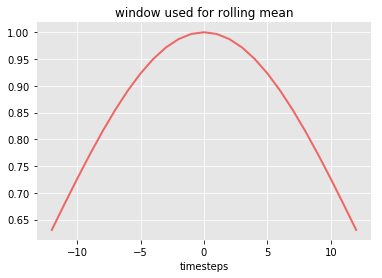

In [3]:
rg.pp_precursors()

In [4]:
rg.list_precur_pp

[('sst_test',
  '/mnt/c/Users/prixn/Documents/Git/RGCPD/RGCPD/../data/preprocessed/sst_1979-2018_2.5deg_Pacific.nc')]

Plotting Corr maps sst, split 0, lag 0

Plotting Corr maps sst, split 0, lag 0



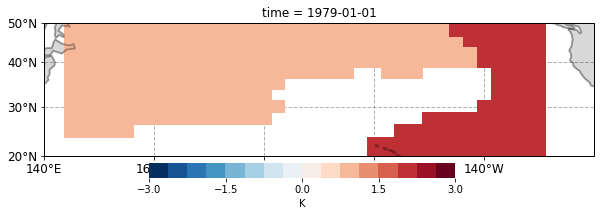

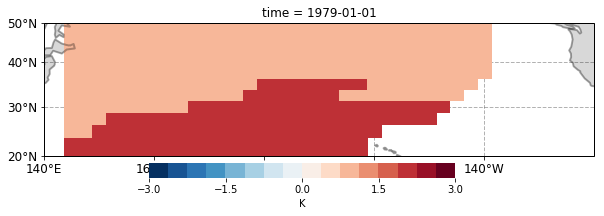

In [5]:
var_filename = rg.list_precur_pp[0][1]
mask = [145.0, 230.0, 20.0, 50.0]
for q in [85, 95]:
    xrclustered, results = cl.dendogram_clustering(var_filename, mask=mask, q=q, kwrgs={'n_clusters':3})
    plot_maps.plot_corr_maps(xrclustered)